**Author**: [Alex FitzGerald](https://www.linkedin.com/in/alex-fitzgerald-0734076a/)

![windjammer header](visuals/windjammer_logo.jpg)

## Overview
This project creates a user-friendly customer lifetime value (CLV) prediction engine able to take in transaction data and return important CLV predictions with a high degree of accuracy for a merchant's entire customer base and individual customers over a selected period of time in the future. The data processing and modeling techniques were validated on a publicly available e-commerce data set from Olist but the app is flexible enough to re-process and model unstructured transaction data from any non-contractual business with continuous purchasing behavior (ex. grocery purchases, e-commerce, movie rentals).

## Business Problem
How much are your customers worth? CLV is a north star metric for marketers and key to many business analyses; sales/marketing activity ROI, sales forecasts, company valuation, churn mitigation tactics, and customer persona analysis. 

Olist, the largest e-commerce department store in Brazil, wants to help the small business merchants who sell goods through their marketplace understand their CLV. Olist makes their money taking a commission on orders placed on their marketplace. They want to help their merchants sell more products and retain those merchants on their marketplace by providing top-notch business analytics.

Olist has decided to create a user friendly app to help their merchants better understand the customers who buy their products through the Olist marketplace. Empowering their merchants with CLV analysis will help merchants improve their strategy and increase sales and commissions through Olist. The addition of a customer insight tool will also improve the retention of merchants on the Olist network. 

To accomplish this project, Olist has hired Windjammer Consulting, a data-science consulting firm.

To test out the app for accuracy, Olist has provided a full transaction data set of purchases from all vendors and asked Windjammer Consulting to return CLV predictions with minimal error (RMSE).
If the model passes muster, they want Windjammer Consulting to create an application that allows merchants to upload their own data and retrieve predictions.

## EDA Notebook

### Exploratory Data Analysis
1. Data base exploration
2. Inital observations

#### Data base exploration
To create a CLV, model we need a customer identifier, purchase timestamp, and purchase value. The data base contains more information than we need so I'm only going to open these three files for further exploration. 
- olist_customers_dataset
    - This dataset has information about the customer and its location. Use it to identify unique customers in the orders dataset.
- olist_order_items_dataset
    - d
- olist_order_payments_dataset
    - This dataset includes data about the orders payment options.

In [1]:
#import zipfile to deal with zipped data
from zipfile import ZipFile
# Create iterate over our files in the zip file and print their names
print("Data base files")
print(" ")
with ZipFile('data/customer_data_base.zip', 'r') as zipObj:
   # Get list of files names in zip
   listOfiles = zipObj.namelist()
   # Iterate over the list of file names in given list & print them
   for elem in listOfiles:
       print(elem)

Data base files
 
olist_customers_dataset.csv
olist_geolocation_dataset.csv
olist_order_items_dataset.csv
olist_order_payments_dataset.csv
olist_order_reviews_dataset.csv
olist_orders_dataset.csv
olist_products_dataset.csv
olist_sellers_dataset.csv
product_category_name_translation.csv


In [2]:
#Inital imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import lifetimes
from zipfile import ZipFile
import random

In [3]:
#Load in our data
# open zipped dataset and save to df's
with ZipFile("data/customer_data_base.zip") as z:
   # open the orders csv file in the dataset
   with z.open("olist_orders_dataset.csv") as a:    
      # read the dataset as dataframe "df"
      orders_df = pd.read_csv(a)
        
   # open the customers csv file in the dataset
   with z.open("olist_customers_dataset.csv") as b:    
      # read the dataset as dataframe "df"
      customers_df = pd.read_csv(b)     
        
   # open the customers csv file in the dataset
   with z.open("olist_order_payments_dataset.csv") as c:    
      # read the dataset as dataframe "df"
      payments_df = pd.read_csv(c)     


![Data_base_schema](visuals/data_base_schema.png)

#### Initial Observations

#### customers_dataset
- All we need from this dataset is `customer_unique_id` and `customer_id`	
- No null or missing values
- We have 96,096 unique customers
    - Total unique `customer_id`: 99,441
    - Total unique `customer_unique_id`: 96,096
- All 27 Brazilian states + federal district (FD) represented
- customer_unique_id represents the unique customer identifier
- customer_id is a key to the orders dataset and represents a unique order id
    - From the data providers, "At our system each order is assigned to a unique customerid."

#### olist_order_items_dataset
- From this dataset we need; `order_purchase_timestamp`, `order_id`, `customer_id`
- `unique order_ids`: 99,441
- `unique customer_ids`: 99,441
- `order_purchase_timestamp` units of time is in days
- Dates range 773 days, from 2016-09-04 to 2018-10-17
- We don't have many observations early in our data set, 2017-04 we get more data
- we see the order status's 'canceled' and 'unavailable' causing issues & we may decide to drop these after joining depending on their order's monetary value

#### olist_order_payments_dataset
- From this dataset we need `payment_value`
- Unique `order_ids`: 99,440
- Duplicate `order_ids`: 4,446
- We have entries with zero `payment_value`
- We have right outliers in `payment_value`



##### customers_dataset

In [4]:
#99441 observations
customers_df.shape

(99441, 5)

In [5]:
#We have no null or na values
customers_df.isnull().sum()

customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

In [6]:
#We have mostly strings and an integer for zip code
customers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 
 3   customer_city             99441 non-null  object
 4   customer_state            99441 non-null  object
dtypes: int64(1), object(4)
memory usage: 3.8+ MB


In [7]:
#Explore head of dataframe
#There is a difference between customer_id and customer_unique_id, let's explore further
customers_df.head()

,customer_id,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,14409,franca,SP
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,9790,sao bernardo do campo,SP
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,1151,sao paulo,SP
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,8775,mogi das cruzes,SP
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,13056,campinas,SP


In [8]:
#As the name suggests, unique_customer_id is a more unique customer identifier
print(f'Total unique customer_id: {len(customers_df["customer_id"].unique())}')
print(f'Total unique customer_unique_id: {len(customers_df["customer_unique_id"].unique())}')

Total unique customer_id: 99441
Total unique customer_unique_id: 96096


In [9]:
#We have 1.03 unique customer_id per every customer_unique_id
len(customers_df["customer_id"].unique())/len(customers_df["customer_unique_id"].unique())

1.0348089410589412

In [10]:
#All 27 Brazilian states + federal district (FD) represented
len(customers_df["customer_state"].unique())

27

In [11]:
customers_df["customer_state"].value_counts()

SP    41746
RJ    12852
MG    11635
RS     5466
PR     5045
SC     3637
BA     3380
DF     2140
ES     2033
GO     2020
PE     1652
CE     1336
PA      975
MT      907
MA      747
MS      715
PB      536
PI      495
RN      485
AL      413
SE      350
TO      280
RO      253
AM      148
AC       81
AP       68
RR       46
Name: customer_state, dtype: int64

##### olist_order_items_dataset

In [12]:
#99441 observations, same as our customers dataset
orders_df.shape

(99441, 8)

In [13]:
#We have only objects. We'll need to translate order_purchase_timestamp to a more useful d type
orders_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB


In [14]:
#translate order_purchase_timestamp to date time
orders_df["order_purchase_timestamp"] = pd.to_datetime(orders_df["order_purchase_timestamp"]).dt.date #normalize()
orders_df["order_purchase_timestamp"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 99441 entries, 0 to 99440
Series name: order_purchase_timestamp
Non-Null Count  Dtype 
--------------  ----- 
99441 non-null  object
dtypes: object(1)
memory usage: 777.0+ KB


In [15]:
#our units of time is in days
orders_df["order_purchase_timestamp"].head()

0    2017-10-02
1    2018-07-24
2    2018-08-08
3    2017-11-18
4    2018-02-13
Name: order_purchase_timestamp, dtype: object

In [16]:
print(f' min date: {orders_df["order_purchase_timestamp"].min()}')
print(f' max date: {orders_df["order_purchase_timestamp"].max()}')
print(f' range: {orders_df["order_purchase_timestamp"].max()-orders_df["order_purchase_timestamp"].min()}')

 min date: 2016-09-04
 max date: 2018-10-17
 range: 773 days, 0:00:00


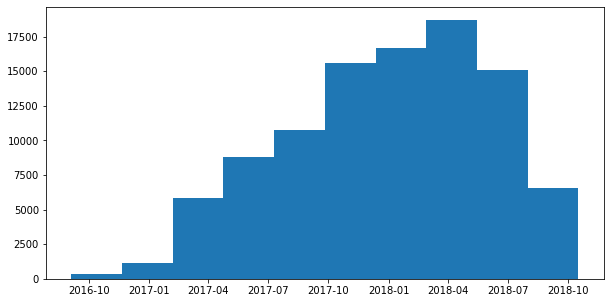

In [17]:
#Dates range 773 days, from 2016-09-04 to 2018-10-17
#We have very few observations early in our data set
fig, ax = plt.subplots(figsize=(10,5))
ax.hist(orders_df["order_purchase_timestamp"]);

In [18]:
#Explore head of dataframe
#Indexed by order_id
#From this dataset we have the required elements for a CLV model; customer identifier, purchase timestamp.
orders_df.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00


In [19]:
#order_id's are unique
print(f'duplicate order_ids: {len(orders_df["order_id"].unique()) - len(orders_df["order_id"])}')
print(f'unique order_ids: {len(orders_df["order_id"].unique())}')

duplicate order_ids: 0
unique order_ids: 99441


In [20]:
#order_id's are unique
print(f'duplicate customer_id: {len(orders_df["customer_id"].unique()) - len(orders_df["customer_id"])}')
print(f'unique customer_ids: {len(orders_df["customer_id"].unique())}')

duplicate customer_id: 0
unique customer_ids: 99441


In [21]:
#We have some order statuses that are concerning for a CLV model; canceled and unavailable
#We have to check if these order types are associated with zero or negative monetary values when we join datasets 
orders_df["order_status"].value_counts()

delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: order_status, dtype: int64

In [22]:
#We have have some null values to deal with in order_approved_at, order_delivered_carrier_date, order_delivered_customer_date
orders_df.isnull().sum()

order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

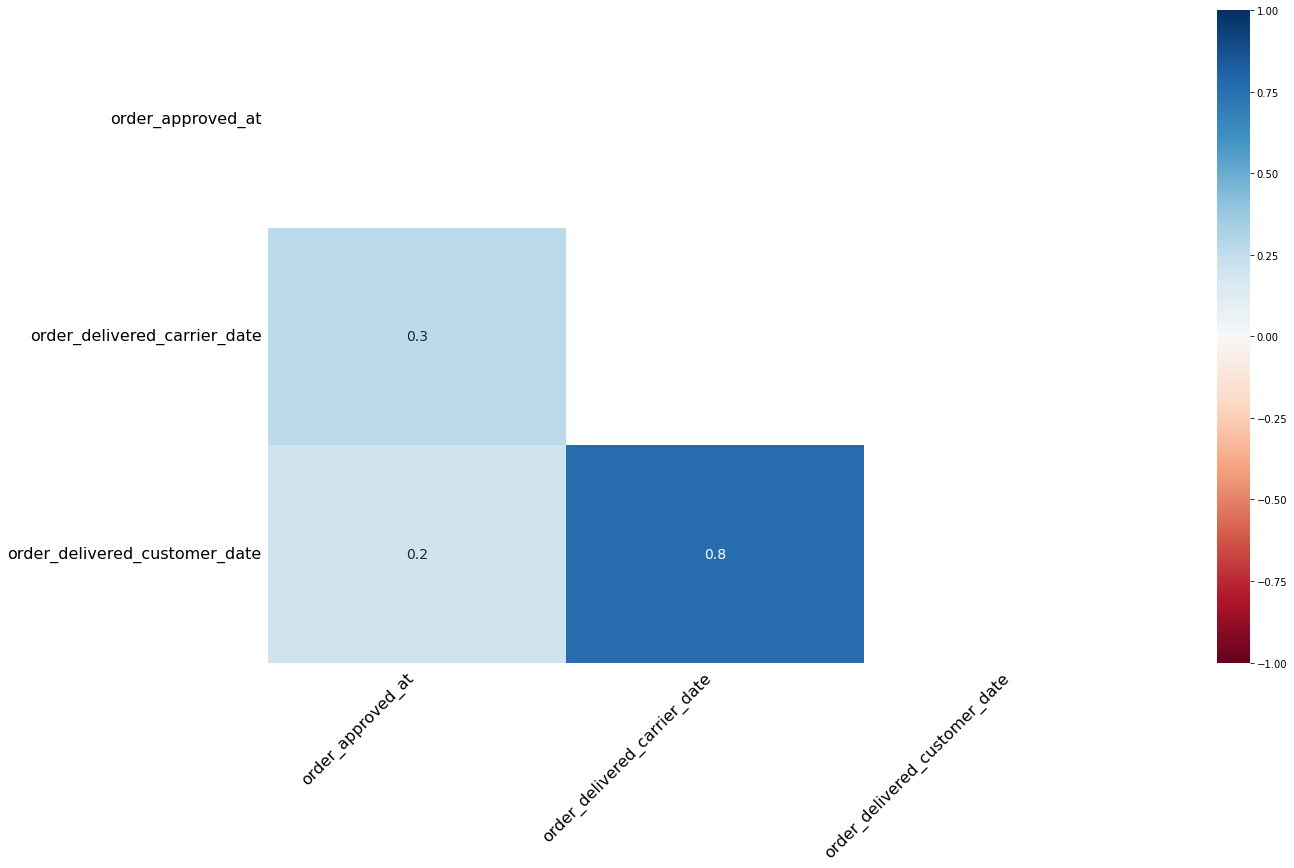

In [23]:
#Let's visualize our errors to understand what might be causing them
#Install missingno
import missingno as msno
msno.heatmap(orders_df);
#It looks like order_delivered_carrier_date and order_delivered_customer_date are connected. When one is in error..
#so is the other (most of the time).

In [24]:
#Dealing with order_approved_at null values first
#We see that there is a strong correlation between order_approved_at being null and "order_status" being 'canceled'
#This makes sense, if the order was canceled, it never got the chance to be approved.
order_approved_at_null_df = orders_df[orders_df["order_approved_at"].isnull() == True]
order_approved_at_null_df["order_status"].value_counts(normalize=True)

canceled     0.88125
delivered    0.08750
created      0.03125
Name: order_status, dtype: float64

In [25]:
#Compared to the order_approved_at_null_df, our full df has a much lower % of 'canceled' status
orders_df["order_status"].value_counts(normalize=True)

delivered      0.970203
shipped        0.011132
canceled       0.006285
unavailable    0.006124
invoiced       0.003158
processing     0.003027
created        0.000050
approved       0.000020
Name: order_status, dtype: float64

In [26]:
order_approved_at_null_df["order_status"]

1130     canceled
1801     canceled
1868     canceled
2029     canceled
2161     canceled
           ...   
97696    canceled
98415    canceled
98909    canceled
99283    canceled
99347    canceled
Name: order_status, Length: 160, dtype: object

In [27]:
#When order status is 'delivered', we'd expect a an "order_approved_at" date but it seems like there..
#were rare instances of data loss. This isn't a big concern bc we don't need 'order_approved_at'
print(f'null order_approved_at & delivered: {len(order_approved_at_null_df[order_approved_at_null_df["order_status"]=="delivered"])}')
order_approved_at_null_df[order_approved_at_null_df["order_status"]=="delivered"].head()

null order_approved_at & delivered: 14


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
5323,e04abd8149ef81b95221e88f6ed9ab6a,2127dc6603ac33544953ef05ec155771,delivered,2017-02-18,NaN,2017-02-23 12:04:47,2017-03-01 13:25:33,2017-03-17 00:00:00
16567,8a9adc69528e1001fc68dd0aaebbb54a,4c1ccc74e00993733742a3c786dc3c1f,delivered,2017-02-18,NaN,2017-02-23 09:01:52,2017-03-02 10:05:06,2017-03-21 00:00:00
19031,7013bcfc1c97fe719a7b5e05e61c12db,2941af76d38100e0f8740a374f1a5dc3,delivered,2017-02-18,NaN,2017-02-22 16:25:25,2017-03-01 08:07:38,2017-03-17 00:00:00
22663,5cf925b116421afa85ee25e99b4c34fb,29c35fc91fc13fb5073c8f30505d860d,delivered,2017-02-18,NaN,2017-02-22 11:23:10,2017-03-09 07:28:47,2017-03-31 00:00:00
23156,12a95a3c06dbaec84bcfb0e2da5d228a,1e101e0daffaddce8159d25a8e53f2b2,delivered,2017-02-17,NaN,2017-02-22 11:23:11,2017-03-02 11:09:19,2017-03-20 00:00:00


In [28]:
#were rare instances of data loss for the 'created status' as well
print(f'null order_approved_at & created: {len(order_approved_at_null_df[order_approved_at_null_df["order_status"]=="created"])}')
order_approved_at_null_df[order_approved_at_null_df["order_status"]=="created"].head()

null order_approved_at & created: 5


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
7434,b5359909123fa03c50bdb0cfed07f098,438449d4af8980d107bf04571413a8e7,created,2017-12-05,NaN,NaN,NaN,2018-01-11 00:00:00
9238,dba5062fbda3af4fb6c33b1e040ca38f,964a6df3d9bdf60fe3e7b8bb69ed893a,created,2018-02-09,NaN,NaN,NaN,2018-03-07 00:00:00
21441,7a4df5d8cff4090e541401a20a22bb80,725e9c75605414b21fd8c8d5a1c2f1d6,created,2017-11-25,NaN,NaN,NaN,2017-12-12 00:00:00
55086,35de4050331c6c644cddc86f4f2d0d64,4ee64f4bfc542546f422da0aeb462853,created,2017-12-05,NaN,NaN,NaN,2018-01-08 00:00:00
58958,90ab3e7d52544ec7bc3363c82689965f,7d61b9f4f216052ba664f22e9c504ef1,created,2017-11-06,NaN,NaN,NaN,2017-12-01 00:00:00


In [29]:
#Now looking at our null values with order delivered dates
null_order_delivered_customer_date_df = orders_df[orders_df["order_delivered_customer_date"].isnull() == True]
null_order_delivered_customer_date_df["order_status"].value_counts(normalize=True)

shipped        0.373356
canceled       0.208769
unavailable    0.205396
invoiced       0.105902
processing     0.101518
delivered      0.002698
created        0.001686
approved       0.000675
Name: order_status, dtype: float64

In [30]:
null_order_delivered_carrier_date_df = orders_df[orders_df["order_delivered_carrier_date"].isnull() == True]
null_order_delivered_carrier_date_df["order_status"].value_counts(normalize=True)

unavailable    0.341559
canceled       0.308469
invoiced       0.176108
processing     0.168817
created        0.002804
approved       0.001122
delivered      0.001122
Name: order_status, dtype: float64

In [31]:
#Again we see the order status's 'canceled' and 'unavailable' causing issues, we'll drop these from our joined dataset

##### olist_order_payments_dataset

In [32]:
payments_df.shape

(103886, 5)

In [33]:
#We see the data we need, 'payment_value' and 'order_id' in appropriate d types
payments_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-null  float64
dtypes: float64(1), int64(2), object(2)
memory usage: 4.0+ MB


In [34]:
#No null values
payments_df.isnull().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [35]:
#data set indexed by order_id
payments_df.head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
0,b81ef226f3fe1789b1e8b2acac839d17,1,credit_card,8,99.33
1,a9810da82917af2d9aefd1278f1dcfa0,1,credit_card,1,24.39
2,25e8ea4e93396b6fa0d3dd708e76c1bd,1,credit_card,1,65.71
3,ba78997921bbcdc1373bb41e913ab953,1,credit_card,8,107.78
4,42fdf880ba16b47b59251dd489d4441a,1,credit_card,2,128.45


In [36]:
print(f'duplicate order_ids: {len(payments_df["order_id"])-len(payments_df["order_id"].unique())}')
print(f'unique order_ids: {len(payments_df["order_id"].unique())}')

duplicate order_ids: 4446
unique order_ids: 99440


In [37]:
#order_id's repeat in our data set
payments_df['order_id'].value_counts()

fa65dad1b0e818e3ccc5cb0e39231352    29
ccf804e764ed5650cd8759557269dc13    26
285c2e15bebd4ac83635ccc563dc71f4    22
895ab968e7bb0d5659d16cd74cd1650c    21
fedcd9f7ccdc8cba3a18defedd1a5547    19
                                    ..
6d2a30c9b7dcee3ed507dc9a601f99e7     1
a7737f6d9208dd56ea498a322ed3c37f     1
646e62df54f3e236eb6d5ff3b31429b8     1
e115da7a49ec2acf622e1f31da65cfb9     1
28bbae6599b09d39ca406b747b6632b1     1
Name: order_id, Length: 99440, dtype: int64

In [38]:
#Exploring an order_id with many instances
#Order_ids represent unique orders and the duplicates in this data-set represent intalment type payments
payments_df[payments_df['order_id'] == "fa65dad1b0e818e3ccc5cb0e39231352"].sort_values(by=["payment_sequential"],ascending=True).head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
14321,fa65dad1b0e818e3ccc5cb0e39231352,1,voucher,1,3.71
23074,fa65dad1b0e818e3ccc5cb0e39231352,2,voucher,1,8.51
65641,fa65dad1b0e818e3ccc5cb0e39231352,3,voucher,1,2.95
9985,fa65dad1b0e818e3ccc5cb0e39231352,4,voucher,1,29.16
28330,fa65dad1b0e818e3ccc5cb0e39231352,5,voucher,1,0.66


In [39]:
payments_df[payments_df['order_id'] == "285c2e15bebd4ac83635ccc563dc71f4"].sort_values(by=["payment_sequential"],ascending=True).head()

,order_id,payment_sequential,payment_type,payment_installments,payment_value
63398,285c2e15bebd4ac83635ccc563dc71f4,1,credit_card,1,1.62
51943,285c2e15bebd4ac83635ccc563dc71f4,2,voucher,1,1.24
75172,285c2e15bebd4ac83635ccc563dc71f4,3,voucher,1,1.40
81583,285c2e15bebd4ac83635ccc563dc71f4,4,voucher,1,2.89
76134,285c2e15bebd4ac83635ccc563dc71f4,5,voucher,1,1.75


In [40]:
#We have some major right outliers in `payments_value`
payments_df.describe()

,payment_sequential,payment_installments,payment_value
count,103886.000000,103886.000000,103886.000000
mean,1.092679,2.853349,154.100380
std,0.706584,2.687051,217.494064
min,1.000000,0.000000,0.000000
25%,1.000000,1.000000,56.790000
50%,1.000000,1.000000,100.000000
75%,1.000000,4.000000,171.837500
max,29.000000,24.000000,13664.080000


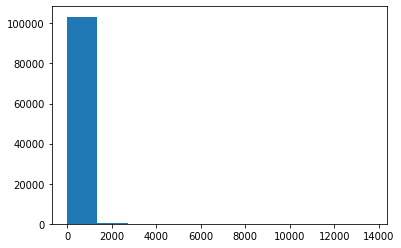

In [41]:
plt.hist(payments_df["payment_value"]);

In [42]:
#We also have some payment_value equal to zero
payments_df.sort_values(["payment_value"])

,order_id,payment_sequential,payment_type,payment_installments,payment_value
57411,00b1cb0320190ca0daa2c88b35206009,1,not_defined,1,0.00
100766,b23878b3e8eb4d25a158f57d96331b18,4,voucher,1,0.00
51280,4637ca194b6387e2d538dc89b124b0ee,1,not_defined,1,0.00
36822,fa65dad1b0e818e3ccc5cb0e39231352,14,voucher,1,0.00
77885,fa65dad1b0e818e3ccc5cb0e39231352,13,voucher,1,0.00
...,...,...,...,...,...
85539,f5136e38d1a14a4dbd87dff67da82701,1,boleto,1,6726.66
49581,fefacc66af859508bf1a7934eab1e97f,1,boleto,1,6922.21
41419,0812eb902a67711a1cb742b3cdaa65ae,1,credit_card,8,6929.31
34370,736e1922ae60d0d6a89247b851902527,1,boleto,1,7274.88


#### Pre-Join Data Cleaning
- **customers_dataset** Drop all but `customer_unique_id` and `customer_id`
- **payments_df**: group by `order_id` and sum to get total `payment_value` per unique order
- **payments_df**: drop all but the `order_id` and  `payment_value` column

In [43]:
#Drop all but `customer_unique_id` and `customer_id`
customers_df_cleaned = customers_df.drop(columns=["customer_zip_code_prefix","customer_city","customer_state"])
#Reset our index
customers_df_cleaned.set_index('customer_id',inplace=True)
customers_df_cleaned

,customer_unique_id
customer_id,
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0
18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3
4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e
b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c
4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066
...,...
17ddf5dd5d51696bb3d7c6291687be6f,1a29b476fee25c95fbafc67c5ac95cf8
e7b71a9017aa05c9a7fd292d714858e8,d52a67c98be1cf6a5c84435bd38d095d
5e28dfe12db7fb50a4b2f691faecea5e,e9f50caf99f032f0bf3c55141f019d99


In [44]:
#group by `order_id` and sum to get total `payment_value` per unique order
payments_df_cleaned = payments_df.groupby("order_id",).sum()

In [45]:
#drop all but the `order_id` and  `payment_value` column
payments_df_cleaned = payments_df_cleaned[["payment_value"]]
payments_df_cleaned 

,payment_value
order_id,
00010242fe8c5a6d1ba2dd792cb16214,72.19
00018f77f2f0320c557190d7a144bdd3,259.83
000229ec398224ef6ca0657da4fc703e,216.87
00024acbcdf0a6daa1e931b038114c75,25.78
00042b26cf59d7ce69dfabb4e55b4fd9,218.04
...,...
fffc94f6ce00a00581880bf54a75a037,343.40
fffcd46ef2263f404302a634eb57f7eb,386.53
fffce4705a9662cd70adb13d4a31832d,116.85


In [46]:
orders_df_cleaned = orders_df.set_index("customer_id")
orders_df_cleaned

,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
customer_id,,,,,,,
9ef432eb6251297304e76186b10a928d,e481f51cbdc54678b7cc49136f2d6af7,delivered,2017-10-02,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
b0830fb4747a6c6d20dea0b8c802d7ef,53cdb2fc8bc7dce0b6741e2150273451,delivered,2018-07-24,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
41ce2a54c0b03bf3443c3d931a367089,47770eb9100c2d0c44946d9cf07ec65d,delivered,2018-08-08,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00
f88197465ea7920adcdbec7375364d82,949d5b44dbf5de918fe9c16f97b45f8a,delivered,2017-11-18,2017-11-18 19:45:59,2017-11-22 13:39:59,2017-12-02 00:28:42,2017-12-15 00:00:00
8ab97904e6daea8866dbdbc4fb7aad2c,ad21c59c0840e6cb83a9ceb5573f8159,delivered,2018-02-13,2018-02-13 22:20:29,2018-02-14 19:46:34,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...,...
39bd1228ee8140590ac3aca26f2dfe00,9c5dedf39a927c1b2549525ed64a053c,delivered,2017-03-09,2017-03-09 09:54:05,2017-03-10 11:18:03,2017-03-17 15:08:01,2017-03-28 00:00:00
1fca14ff2861355f6e5f14306ff977a7,63943bddc261676b46f01ca7ac2f7bd8,delivered,2018-02-06,2018-02-06 13:10:37,2018-02-07 23:22:42,2018-02-28 17:37:56,2018-03-02 00:00:00
1aa71eb042121263aafbe80c1b562c9c,83c1379a015df1e13d02aae0204711ab,delivered,2017-08-27,2017-08-27 15:04:16,2017-08-28 20:52:26,2017-09-21 11:24:17,2017-09-27 00:00:00


In [47]:
#join customers and orders together with customer_id
lifetimes_object_df_uncleaned = pd.concat([customers_df_cleaned,orders_df_cleaned], axis=1, join='inner')
#check that we retained all our unique customer_id's
len(lifetimes_object_df_uncleaned) == len(customers_df_cleaned) == len(orders_df_cleaned)

True

In [48]:
lifetimes_object_df_uncleaned.head(2)

,customer_unique_id,order_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
customer_id,,,,,,,,
06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,delivered,2017-05-16,2017-05-16 15:22:12,2017-05-23 10:47:57,2017-05-25 10:35:35,2017-06-05 00:00:00
18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,delivered,2018-01-12,2018-01-12 20:58:32,2018-01-15 17:14:59,2018-01-29 12:41:19,2018-02-06 00:00:00


In [49]:
#reset index to order_id so we can join with payment info
lifetimes_object_df_uncleaned.set_index("order_id",inplace=True)

In [50]:
#Join with payment info
lifetimes_object_df_uncleaned = pd.concat([lifetimes_object_df_uncleaned,payments_df_cleaned], axis=1, join='inner')

In [51]:
lifetimes_object_df_uncleaned.to_csv("data/lifetimes_object_df_uncleaned.csv")

#### Post-Join Data Cleaning
- Drop `payment_value` less or equal to zero
- Drop 'canceled' and 'unavailable' rows in the `order_status` column

In [52]:
#Drop `payment_value` less or equal to zero
lifetimes_object_df = lifetimes_object_df_uncleaned[lifetimes_object_df_uncleaned["payment_value"]>0]

In [53]:
#Drop 'canceled' and 'unavailable' rows in the `order_status` column
lifetimes_object_df = lifetimes_object_df[lifetimes_object_df["order_status"]!="canceled"]
lifetimes_object_df = lifetimes_object_df[lifetimes_object_df["order_status"]!="unavailable"]

In [54]:
#counting dropped rows
print(f'We dropped {len(lifetimes_object_df_uncleaned) - len(lifetimes_object_df)} rows')

We dropped 1234 rows


In [55]:
lifetimes_object_df.to_csv("data/lifetimes_object_df.csv")